<a href="https://colab.research.google.com/github/Megha-alt/-Live-Earthquake-Monitoring-and-ML-Risk-Predictor/blob/main/MODELLL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Live Earthquake Monitoring & ML Risk Predictor

In [1]:


import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import pickle
import requests
import pickle
import pandas as pd
import os
from datetime import datetime, timedelta
from google.colab import files



uploaded = files.upload()
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)


Saving earthquake_training.csv to earthquake_training.csv


In [5]:
# training model

X = df[["magnitude", "depth"]]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)


RandomForestClassifier()

In [6]:
pickle.dump(classifier, open("classifier_model.pkl", "wb"))
print("Model saved as classifier_model.pkl")
pickle.dump(classifier, open("model.pkl", "wb"))
print("Model saved as model.pkl")

Model saved as classifier_model.pkl
Model saved as model.pkl


In [7]:
#calculating Risk score
df["risk_score"] = (df["magnitude"] * 12) + (df["depth"] * 0.5)
df["risk_score"] = df["risk_score"].clip(0, 100)

X_r = df[["magnitude", "depth"]]
y_r = df["risk_score"]

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_r, y_r, test_size=0.2)

regressor = RandomForestRegressor()
regressor.fit(X_train_r, y_train_r)


RandomForestRegressor()

In [9]:
pickle.dump(regressor, open("regressor_model.pkl", "wb"))
print("Model saved as regressor_model.pkl")
pickle.dump(regressor, open("model.pkl", "wb"))
print("Model saved as model.pkl")

Model saved as regressor_model.pkl
Model saved as model.pkl


In [14]:

# Fetching live earthquake data

url = "https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_day.geojson"
data = requests.get(url).json()

records = []

for eq in data["features"]:
    magnitude = eq["properties"]["mag"]
    depth = eq["geometry"]["coordinates"][2]
    time_ms = eq["properties"]["time"]

    utc_time = datetime.utcfromtimestamp(time_ms / 1000)
    ist_time = utc_time + timedelta(hours=5, minutes=30)

    place = eq["properties"]["place"]

    records.append([magnitude, depth, ist_time, place])

df = pd.DataFrame(records, columns=["magnitude", "depth", "time_IST", "place"])

#  MOST RECENT EARTHQUAKE
latest = df.iloc[0]
magnitude = latest["magnitude"]
depth = latest["depth"]
ist_time = latest["time_IST"]
place = latest["place"]



#  LOAD MODEL

model = pickle.load(open("model.pkl", "rb"))


#  ML PREDICTION

live_df = pd.DataFrame([[magnitude, depth]], columns=["magnitude", "depth"])
result = model.predict(live_df)[0]

print("Prediction:", result)


Prediction: 51.989


/tmp/ipython-input-1764826818.py:13: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  utc_time = datetime.utcfromtimestamp(time_ms / 1000)


In [15]:
print("Recent Earthquake Analysis------")
print("Live Earthquake Data:")
print("Magnitude:", magnitude)
print("Depth:", depth)
print("Location:", place)
print("Time (IST):", ist_time)

# Load correct models
classifier = pickle.load(open("classifier_model.pkl", "rb"))
regressor = pickle.load(open("regressor_model.pkl", "rb"))

# Prepare DF for prediction
input_df = pd.DataFrame([[magnitude, depth]], columns=["magnitude", "depth"])


#  CLASSIFIER PREDICTION

prediction = classifier.predict(input_df)[0]   # NORMAL or SPIKE

# Probability output
probabilities = classifier.predict_proba(input_df)[0]

label_order = classifier.classes_   # ['NORMAL', 'SPIKE'] or similar

proba_dict = {
    label_order[0]: probabilities[0],
    label_order[1]: probabilities[1]
}

print("\n--- ML PREDICTION (Classifier) ---")
print("Prediction:", result)
print("Prediction:", prediction)
print("Probability Breakdown:")
for label, proba in proba_dict.items():
    print(f"{label}: {proba*100:.2f}%")


# REGRESSOR RISK PREDICTION

risk_pred = regressor.predict(input_df)[0]
risk_pred = min(max(risk_pred, 0), 100)

print("\n--- ML RISK REGRESSION ---")
print("Predicted Risk Score:", round(risk_pred, 2))

# Risk label
if risk_pred < 20:
    level = "SAFE"
elif risk_pred < 40:
    level = "LOW RISK"
elif risk_pred < 60:
    level = "MODERATE RISK"
elif risk_pred < 80:
    level = "HIGH RISK"
else:
    level = "DANGEROUS"

print("Risk Level:", level)
print("Safety Status:", "SAFE" if risk_pred < 50 else "UNSAFE")


Recent Earthquake Analysis------
Live Earthquake Data:
Magnitude: 1.976209348650902
Depth: 108.4832992553711
Location: 56 km NNW of Petersville, Alaska
Time (IST): 2025-11-21 20:07:08.539000

--- ML PREDICTION (Classifier) ---
Prediction: 51.989
Prediction: NORMAL
Probability Breakdown:
NORMAL: 52.00%
SPIKE: 48.00%

--- ML RISK REGRESSION ---
Predicted Risk Score: 51.99
Risk Level: MODERATE RISK
Safety Status: UNSAFE


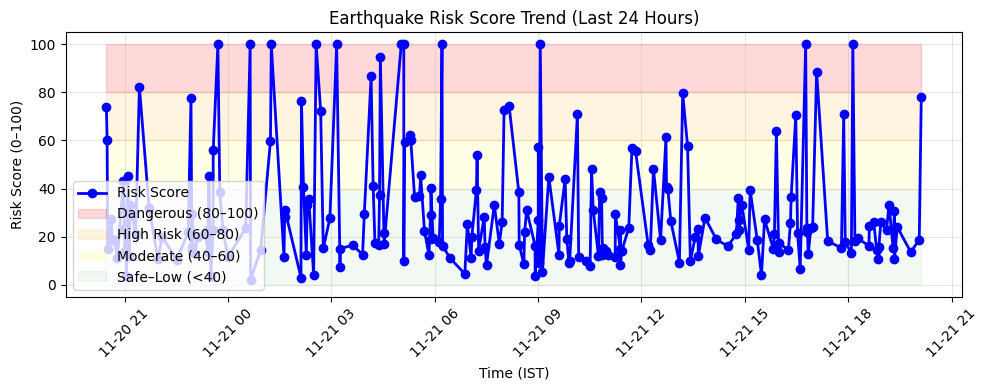

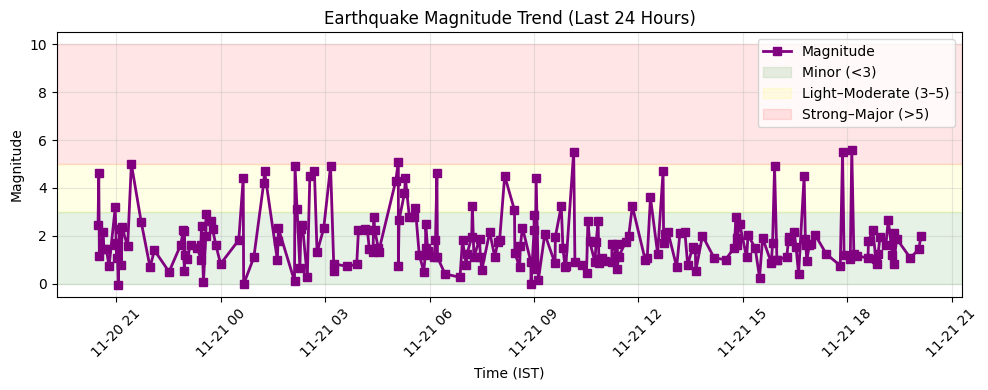

In [16]:

# RISK TREND GRAPH (LAST 24 HOURS)


import matplotlib.pyplot as plt
import numpy as np

# Calculate risk values for full dataset
risk_values = [(m * 12) + (d * 0.5) for m, d in zip(df["magnitude"], df["depth"])]
risk_values = [min(x, 100) for x in risk_values]

df["risk_score"] = risk_values

plt.figure(figsize=(10, 4))
plt.plot(df["time_IST"], df["risk_score"], marker='o',color="blue", linewidth=2, label="Risk Score")

# Shaded Risk Zones
plt.fill_between(df["time_IST"], 80, 100, color="red", alpha=0.15, label="Dangerous (80–100)")
plt.fill_between(df["time_IST"], 60, 80, color="orange", alpha=0.12, label="High Risk (60–80)")
plt.fill_between(df["time_IST"], 40, 60, color="yellow", alpha=0.10, label="Moderate (40–60)")
plt.fill_between(df["time_IST"], 0, 40, color="green", alpha=0.05, label="Safe–Low (<40)")

plt.title("Earthquake Risk Score Trend (Last 24 Hours)")
plt.xlabel("Time (IST)")
plt.ylabel("Risk Score (0–100)")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.legend()
plt.show()


# MAGNITUDE TREND GRAPH


plt.figure(figsize=(10, 4))
plt.plot(df["time_IST"], df["magnitude"], marker='s', linewidth=2, color='purple', label="Magnitude")

# Highlight threshold zones (optional but looks nice)
plt.axhspan(0, 3, color='green', alpha=0.10, label='Minor (<3)')
plt.axhspan(3, 5, color='yellow', alpha=0.10, label='Light–Moderate (3–5)')
plt.axhspan(5, 10, color='red', alpha=0.10, label='Strong–Major (>5)')

plt.title("Earthquake Magnitude Trend (Last 24 Hours)")
plt.xlabel("Time (IST)")
plt.ylabel("Magnitude")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

